In [1]:
# pip install hvplot

In [2]:
# Dependencies
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# import hvplot.pandas as hvplot
import plotly as plt
import plotly.express as px

In [3]:
# Read in candidates data
df1 = pd.read_csv("candidates_clean.csv")
df_cand = df1.copy()
df_cand.head()

,unique_key,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,1996N00000948,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,L
1,1996N00004451,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,L
2,1996N00001670,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,L
3,1996N00000525,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,L
4,1996N00005551,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,W


In [4]:
# Read in PAC data 
# df2 = pd.read_csv("pacs.csv", on_bad_lines='skip')
# df_pac = df2.copy()
# df_pac.head()

# Cleaned
# df2 = pd.read_csv('pacs_clean.csv')
# df_pac = df2.copy()
# df_pac.head()

## <font color = 'gold'>Clean

In [5]:
# Handle nulls
# df_pac.isnull().sum()

In [6]:
# df_pac = df_pac.dropna()

In [7]:
# df_pac.duplicated().sum()

In [8]:
# Drop duplicates
# df_pac = df_pac.drop_duplicates()

In [9]:
# df_pac.to_csv('pacs_clean.csv')

In [10]:
# # Join pac and candidates dfs
# df_paccand = df_cand.merge(df_pac, how='left', on='cid')
# df_paccand.head()

## <font color = 'gold'>Explore Features

In [11]:
# See if cycle_candidate is significant
# if there are W and blank c_c, then it's significant
# if there L for every blank c_c, insignificant - drop
# df3 = df_cand[(df_cand['cycle_candidate'] == ' ') & (df_cand['result'] == 'W')]
# df3.head(10)

# KEEP for now, but test both ways.

In [12]:
# Choose columns for features
columns = ['party', 'crpico', 'raised_from_pacs', 'raised_from_individuals',	'raised_total',	'raised_unitemized', 'result']

# # consider dropping later:
#   #cycle_candidate
#   #nopacs
#   #dist_id_currently_held

df_features = df_cand[columns]
df_features.head()

,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,C,0.0,6000.0,6000,0.0,L
1,R,C,492.0,97408.0,264254,166354.0,L
2,R,C,202815.0,618935.0,1636414,814664.0,L
3,U,C,0.0,266.0,266,0.0,L
4,R,I,130384.0,99600.0,399980,169996.0,W


In [13]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19384 entries, 0 to 19383
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   party                    19384 non-null  object 
 1   crpico                   19384 non-null  object 
 2   raised_from_pacs         19384 non-null  float64
 3   raised_from_individuals  19384 non-null  float64
 4   raised_total             19384 non-null  int64  
 5   raised_unitemized        19384 non-null  float64
 6   result                   19384 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 1.0+ MB


In [14]:
df_features.nunique()

party                          4
crpico                         5
raised_from_pacs           11607
raised_from_individuals    15530
raised_total               17987
raised_unitemized          14653
result                         2
dtype: int64

## <font color = 'gold'>Preprocessing
### Categorical Variables
#### <font color = 'skyblue'>Bucket

In [15]:
for col in df_features.columns:
  print(df_features[col].value_counts())

# drop nopacs, bucket crpico 

R    9480
D    8594
U     768
3     542
Name: party, dtype: int64
C    9300
I    5568
O    4438
       77
3       1
Name: crpico, dtype: int64
0.0          4348
1000.0        338
500.0         241
5000.0        154
2000.0        146
             ... 
142165.0        1
2394678.0       1
637791.0        1
325226.0        1
345241.0        1
Name: raised_from_pacs, Length: 11607, dtype: int64
 0.0         853
 1000.0      124
 500.0       118
 250.0        63
 200.0        53
            ... 
 368600.0      1
 289948.0      1
 9440.0        1
 20315.0       1
-127.0         1
Name: raised_from_individuals, Length: 15530, dtype: int64
 500         103
 1000         78
 250          41
 200          41
 300          31
            ... 
 1670835       1
 23363069      1
 333074        1
 28243         1
-127           1
Name: raised_total, Length: 17987, dtype: int64
0.0         2895
100.0         45
200.0         27
50.0          21
25.0          19
            ... 
744356.0       1
123060.

In [16]:
# get value counts variable
crpico_type = df_features['crpico'].value_counts()
crpico_type

C    9300
I    5568
O    4438
       77
3       1
Name: crpico, dtype: int64

In [17]:
# Determine which values to replace if counts are less than 100?
replace_crpico = list(crpico_type[crpico_type < 100].index)

# Replace in dataframe
for cls in replace_crpico:
    df_features.crpico = df_features.crpico.replace(cls,"Other")
    
# Check to make sure binning was successful
df_features.crpico.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


C        9300
I        5568
O        4438
Other      78
Name: crpico, dtype: int64

In [18]:
# encode W/L of 'result' column by mapping
x = {'W': 1, 'L': 0}
df_features = df_features.replace(x)
df_features.head()

,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,3,C,0.0,6000.0,6000,0.0,0
1,R,C,492.0,97408.0,264254,166354.0,0
2,R,C,202815.0,618935.0,1636414,814664.0,0
3,U,C,0.0,266.0,266,0.0,0
4,R,I,130384.0,99600.0,399980,169996.0,1


#### <font color = 'skyblue'>Encode

In [19]:
# generate categorical variable list
catvars = df_features.dtypes[df_features.dtypes == 'object'].index
catvars

Index(['party', 'crpico'], dtype='object')

In [20]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_features[catvars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(catvars)
encode_df.head()

,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [21]:
# Merge one-hot encoded features and drop the originals
encoded_df = df_features.merge(encode_df, left_index=True, right_index=True)
encoded_df = encoded_df.drop(catvars, axis=1)
encoded_df.head()

,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,0.0,6000.0,6000,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,492.0,97408.0,264254,166354.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,202815.0,618935.0,1636414,814664.0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,266.0,266,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,130384.0,99600.0,399980,169996.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### <font color= 'skyblue'>Create Features and Target Arrays

In [22]:
# Split preprocessed data into features and target arrays
X = encoded_df.drop('result', axis=1).values
y = df_features.result.values

<font color= 'skyblue'>Split to Training and Testing data

In [23]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

<font color= 'skyblue'>Standard Scale

In [24]:
# Scale / Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# view data to ensure successful standardization
X_train_scaled[:1]

array([[-0.1858122 , -0.09324757, -0.13775195, -0.21476842, -0.16841996,
         1.11855324, -0.97714917, -0.20347976, -0.96684456, -0.63163339,
         1.84069765, -0.06162431]])

## <font color='gold'>Model - Random Forest Classifier

In [25]:
# Resample the training data with the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=43)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=43)

In [26]:
# Calculate the accuracy score
y_true = y_test
y_pred = clf.predict(X_test_scaled)
print(f"Accuracy Score: {accuracy_score(y_true, y_pred)}")
print("\n---------------------------------------------------------------------------------\n")


# Display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Lose", "Win"], columns=["Predicted Lose", "Predicted Win"])
print(cm_df)
print("\n---------------------------------------------------------------------------------\n")

# Print the imbalanced classification report
print(classification_report(y_true, y_pred))

Accuracy Score: 0.9335534461411473

---------------------------------------------------------------------------------

      Predicted Lose  Predicted Win
Lose            3088            173
Win              149           1436

---------------------------------------------------------------------------------

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3261
           1       0.89      0.91      0.90      1585

    accuracy                           0.93      4846
   macro avg       0.92      0.93      0.92      4846
weighted avg       0.93      0.93      0.93      4846



## <font color='gold'>KMeans Clustering

In [27]:
# Initialize df from copy
df_clust = df1.copy()
df_clust.head()

,unique_key,id,cycle,fec_cand_id,cid,first_last_party,party,dist_id_run_for,dist_id_currently_held,current_candidate,cycle_candidate,crpico,recip_code,nopacs,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,result
0,1996N00000948,56756,1996,P80001118,N00000948,Lenora B Fulani (3),3,PRES,,,,C,3L,,0.0,6000.0,6000,0.0,L
1,1996N00004451,58068,1996,S6MN00143,N00004451,Stephen Bonsal Young (R),R,MNS1,,,Y,C,RL,,492.0,97408.0,264254,166354.0,L
2,1996N00001670,57382,1996,S6DE00073,N00001670,Raymond J Clatworthy (R),R,DES2,,Y,Y,C,RL,,202815.0,618935.0,1636414,814664.0,L
3,1996N00000525,57290,1996,S4VT00066,N00000525,Gavin Terence Mills (I),U,VTS1,,,,C,3L,,0.0,266.0,266,0.0,L
4,1996N00005551,53386,1996,H2OK05045,N00005551,Ernest J Istook (R),R,OK05,OK05,Y,Y,I,RW,,130384.0,99600.0,399980,169996.0,W


In [28]:
# isolate first_last_
name = pd.DataFrame(df_clust.first_last_party)
name.head()

,first_last_party
0,Lenora B Fulani (3)
1,Stephen Bonsal Young (R)
2,Raymond J Clatworthy (R)
3,Gavin Terence Mills (I)
4,Ernest J Istook (R)


In [29]:
# Choose features
df_clust = df_clust[['party', 'current_candidate', 'crpico', 'raised_from_pacs',	'raised_from_individuals', 'raised_unitemized']]
df_clust.head()

,party,current_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized
0,3,,C,0.0,6000.0,0.0
1,R,,C,492.0,97408.0,166354.0
2,R,Y,C,202815.0,618935.0,814664.0
3,U,,C,0.0,266.0,0.0
4,R,Y,I,130384.0,99600.0,169996.0


In [30]:
# encode cat variables
X = pd.get_dummies(df_clust, columns=['party','current_candidate','crpico'])
X.head()

,raised_from_pacs,raised_from_individuals,raised_unitemized,party_3,party_D,party_R,party_U,current_candidate_,current_candidate_Y,crpico_,crpico_3,crpico_C,crpico_I,crpico_O
0,0.0,6000.0,0.0,1,0,0,0,1,0,0,0,1,0,0
1,492.0,97408.0,166354.0,0,0,1,0,1,0,0,0,1,0,0
2,202815.0,618935.0,814664.0,0,0,1,0,0,1,0,0,1,0,0
3,0.0,266.0,0.0,0,0,0,1,1,0,0,0,1,0,0
4,130384.0,99600.0,169996.0,0,0,1,0,0,1,0,0,0,1,0


In [31]:
# Standardize data
X_scaled = StandardScaler().fit_transform(X)
X_scaled[0:1]

array([[-0.19725278, -0.09257291, -0.09864846,  5.89608664, -0.89245628,
        -0.97836037, -0.20311286,  1.28631846, -1.28631846, -0.06315212,
        -0.00718273,  1.04129778, -0.63483148, -0.54491801]])

### PCA

In [32]:
# Reduce dimensions using PCA
pca = PCA(n_components=3)
cand_pca = pca.fit_transform(X_scaled)

In [33]:
# Create a DataFrame with the three principal components.
pca_df = pd.DataFrame(data=cand_pca, columns=["PC 1", "PC 2", "PC 3"], index=df_clust.index)
pca_df.head(10)

,PC 1,PC 2,PC 3
0,-1.732795,-0.153776,0.323420
1,-2.062598,0.641335,-0.902557
2,0.177299,-0.007013,-1.530182
3,-1.797090,-0.112219,0.365533
4,1.475337,-0.352080,-1.768463
5,-2.081065,0.594597,-0.908521
6,-2.068609,0.625936,-0.904550
7,-1.829448,0.469882,0.679694
8,-2.107566,1.191487,-0.592480
9,-1.497696,0.009381,1.800829


### Elbow Curve

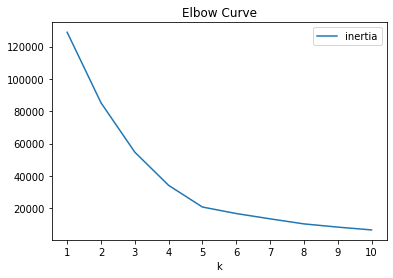

In [34]:
# Create an Elbow Curve to find the best value for K.

inertia = []
k = list(range(1,11))

# Get / store inertia values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pca_df)
    inertia.append(km.inertia_)
    
# Define DF to plot Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot(kind='line', x='k', y='inertia', title="Elbow Curve", xticks=k)

Clustering

In [35]:
# Initialize the K-Means model.
model = KMeans(n_clusters=5, random_state=0)

# Fit the model
model.fit(pca_df)

# Predict clusters
predicts = model.predict(pca_df)

In [36]:
# Create a new DataFrame including predicted clusters and candidate features.
# Concatentate the df_clust and pcs_df DataFrames on the same columns.
clustered_df = df_clust.join(pca_df, how='inner')

#  Add a new column, "CoinName" to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
clustered_df = clustered_df.join(name, how='inner')

#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df['Class'] = model.labels_

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(19384, 11)


,party,current_candidate,crpico,raised_from_pacs,raised_from_individuals,raised_unitemized,PC 1,PC 2,PC 3,first_last_party,Class
0,3,,C,0.0,6000.0,0.0,-1.732795,-0.153776,0.323420,Lenora B Fulani (3),4
1,R,,C,492.0,97408.0,166354.0,-2.062598,0.641335,-0.902557,Stephen Bonsal Young (R),4
2,R,Y,C,202815.0,618935.0,814664.0,0.177299,-0.007013,-1.530182,Raymond J Clatworthy (R),2
3,U,,C,0.0,266.0,0.0,-1.797090,-0.112219,0.365533,Gavin Terence Mills (I),4
4,R,Y,I,130384.0,99600.0,169996.0,1.475337,-0.352080,-1.768463,Ernest J Istook (R),2
5,R,,C,0.0,5576.0,12474.0,-2.081065,0.594597,-0.908521,Stephen Wayne Hofman (R),4
6,R,,C,2000.0,72177.0,110748.0,-2.068609,0.625936,-0.904550,Olivia Coggin Eudaly (R),4
7,U,,O,0.0,3436.0,1946.0,-1.829448,0.469882,0.679694,H Harold Hardee (I),1
8,R,,O,500.0,40500.0,61320.0,-2.107566,1.191487,-0.592480,Joseph Dr Smith (R),4
9,D,,C,0.0,42841.0,35855.0,-1.497696,0.009381,1.800829,Godfrey J Dillard (D),1


In [37]:
clustered_df.groupby('Class')['Class'].count()

Class
0    5577
1    3080
2    6516
3       6
4    4205
Name: Class, dtype: int64

In [38]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="Class",
    symbol="Class",
    hover_name="first_last_party",
    hover_data=["crpico"],
    width=800
)
fig.update_layout(legend=dict(x=0,y=1))
fig.show()

## <font color='gold'>2022 Predictions

In [50]:
df3 = pd.read_csv('cand_summary_2022_clean.csv')
df_2022 = df3.copy()
df_2022.fillna('',inplace=True)
df_2022 = df_2022[df_2022['raised_total'] > 0]
df_2022.head()

,first_last_party,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
5,"VIRASINGH, VICTORIA",D,C,15650.00,225138.07,243859.84,62498.32
6,"CAO, HUNG",R,C,32700.00,949909.38,982705.38,424071.73
7,"TAYLOR, BROOKE",R,C,17400.00,48510.25,51410.25,1810.25
12,"CRUZ, ROBERT ROB",R,C,0.00,140289.60,149729.76,19607.02
13,"FRANCE, MIKE",R,C,22937.75,472898.26,495836.01,179880.71


In [51]:
features_2022 = df_2022.drop('first_last_party', axis=1)
features_2022.head()

,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized
5,D,C,15650.00,225138.07,243859.84,62498.32
6,R,C,32700.00,949909.38,982705.38,424071.73
7,R,C,17400.00,48510.25,51410.25,1810.25
12,R,C,0.00,140289.60,149729.76,19607.02
13,R,C,22937.75,472898.26,495836.01,179880.71


#### <font color='skyblue'>Encode

In [52]:
# generate categorical variable list
catvars = features_2022.dtypes[features_2022.dtypes == 'object'].index
catvars

Index(['party', 'crpico'], dtype='object')

In [53]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_features[catvars]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(catvars)
encode_df.head()

,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [54]:
# Merge one-hot encoded features and drop the originals
encoded_df = features_2022.merge(encode_df, left_index=True, right_index=True)
encoded_df = encoded_df.drop(catvars, axis=1)
encoded_df.head()

,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,party_3,party_D,party_R,party_U,crpico_C,crpico_I,crpico_O,crpico_Other
5,15650.00,225138.07,243859.84,62498.32,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,32700.00,949909.38,982705.38,424071.73,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,17400.00,48510.25,51410.25,1810.25,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
12,0.00,140289.60,149729.76,19607.02,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
13,22937.75,472898.26,495836.01,179880.71,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [55]:
# Split preprocessed data into features
X = encoded_df.values

In [56]:
# Scale / Standardize feature data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# view data to ensure successful standardization
X_scaled[:1]

array([[-0.28674329, -0.15698087, -0.18746009, -0.10679587, -0.17089789,
        -0.84480686,  0.99203809, -0.23220129,  1.01692986, -0.57765794,
        -0.58504246, -0.05663655]])

In [57]:
# Predict 2022 election Results
predictions_2022 = clf.predict(X_scaled)

In [58]:
preds = pd.Series(predictions_2022, name='preds')
predicted_2022 = df_2022.merge(preds, left_index=True, right_index=True)

In [59]:
pd.set_option('display.max_rows', None)
predicted_2022['preds'] = predicted_2022['preds'].replace({
    0: 'L',
    1: 'W'
})
predicted_2022

,first_last_party,party,crpico,raised_from_pacs,raised_from_individuals,raised_total,raised_unitemized,preds
5,"VIRASINGH, VICTORIA",D,C,15650.00,225138.07,243859.84,62498.32,L
6,"CAO, HUNG",R,C,32700.00,949909.38,982705.38,424071.73,W
7,"TAYLOR, BROOKE",R,C,17400.00,48510.25,51410.25,1810.25,L
12,"CRUZ, ROBERT ROB",R,C,0.00,140289.60,149729.76,19607.02,L
13,"FRANCE, MIKE",R,C,22937.75,472898.26,495836.01,179880.71,W
14,"BUSCH VALENTINE, TRUDY",D,O,7900.00,397774.01,415784.72,72490.01,L
15,"HARTWICK, STEVE",D,C,0.00,2050.00,2050.00,550.00,L
17,"STEVENSON, JAYME MRS.",R,C,0.00,223356.90,223356.90,10311.00,L
18,"PANSING BROOKS, PATTY",D,C,16340.00,1023832.23,1040172.23,293324.63,L
19,"FITZGERALD, SCOTT",R,I,235750.00,507694.76,743444.76,123560.95,L


In [49]:
predicted_2022['preds'].value_counts()

L    3105
W    1262
Name: preds, dtype: int64